# HANDL - Permutation Tests

The goal of HANDL is to support the transfer of biological knowledge across species.  It does so by constructing explicit measures of functional similarity between proteins in different species.   HANDL (Homology Assessment across Networks using Diffusion and Landmarks) creates a functional embedding in which proteins from different species are embedded in the same vector space. In the paper [1] it is shown that inner products in this space _(HANDL homology scores)_, as well as the vectors themselves _(HANDL embeddings)_, capture functional similarity across species and are useful for a variety of functional tasks.

[1] [A Multi-Species Functional Embedding Integrating Sequence and
Network Structure](https://www.biorxiv.org/content/early/2017/12/04/229211), Mark D.M. Leiserson, Jason Fan, Anthony Cannistra, Inbar Fried, Tim Lim, Thomas Schaffner, Mark Crovella, and Benjamin Hescott, _Proceedings of RECOMB 2018,_ Paris, France.

## Background

An overview of HANDL is shown in the figure below.  Starting with a source and a target network, HANDL computes diffusion kernels for each network. The diffusion kernels are factored, resulting in a representation in which each node becomes a vector, and inner products correlate with functional similarities. HANDL then solves a linear system to create a single embedding of both vector sets, allowing for functional comparisons between proteins across the two networks.

![HANDL Overview](figures/handl-methods.png)

As shown in the figure, HANDL works with the notion of a _source_ species and one or more _target_ species.  The proteins of the target species are embedded into a space defined by the source species.

## Permutation test

todo: lorem ipsum

Let's first import the required python modules and perform some setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.append(os.getcwd() + "/../src")

%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
import handl
import util
from collections import defaultdict

# Random psuedograph model

To generate random graphs conditioned on degree sequences, we use NetworkX to generate random psuedographs (graphs with self loops and parallel edges) with an algorithm from M.E.J. Newman (“The structure and function of complex networks”, SIAM REVIEW 45-2, pp 167-256, 2003).

Notice that the generated graphs are not necessarily connected. We will use this random graph generation model as a heuristic for our permutation test.

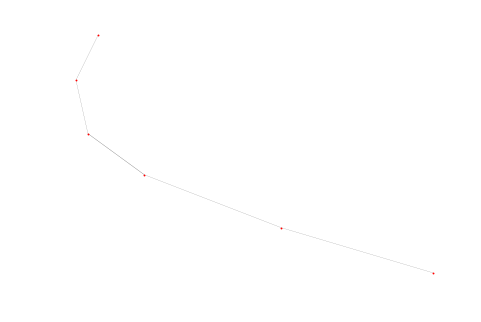

In [3]:
def draw(G):
    nx.draw(G, node_shape='.', node_size=3, width=0.1)
def draw_random1():
    degree_sequence = [1,3,2,3,2,1]
    G = nx.configuration_model(degree_sequence)
    draw(G)
draw_random1()

# Permutation test with S.c and S.p Protein-protein Interaction Networks

We first load the interaction networks from their edgelists.

In [4]:
sp_ppi_path = "../data/ppi/biogrid/sp/sp-biogrid.v3.4.157-ppi-std.tsv" 
sc_ppi_path = "../data/ppi/biogrid/sc/sc-biogrid.v3.4.157-ppi-std.tsv" 
sc_G = util.simple_two_core(nx.read_edgelist(sc_ppi_path, encoding='ascii'), verbose=False)
sp_G = util.simple_two_core(nx.read_edgelist(sp_ppi_path, encoding='ascii'), verbose=False)

We can draw the _S.p_ PPI network just for fun

In [5]:
#draw(sp_G)

### Generating random graphs of 'fixed' (similar) degree sequence

Given a seed graph $G$ we want to return a random graph $G'$ of the same size and same degree sequence as $G$.

We could use an edge swapping algorithm to generate random graphs with fixed degree sequences but this algorithm is slow. Instead, we use a heuristic to generate random graphs with degree sequences "close" to what we would like by doing the following.

Given a graph $G$ we do the following:
0. Obtain degree sequence, $D$, from $G$, and shuffle it
1. Generate psuedograph $G'$ using Newman's algorithm for generating psuedographs using $D$
2. Remove self edges and collapse parallel edges in $G'$
3. If $G'$ and $G$ have the same nodes, return $G'$
4. Else, go to 1.

Notice that step 2. might remove nodes from $G'$. To ensure that the returned graph $G'$ and $G$ have the same nodes, we simply repeat the graph generation algorithm until no nodes are removed in step 2.

In [6]:
def perturbed_graph(seed_graph):
    ''' Returns random graph with approximately the same degree distribution as given seed graph'''
    # Generate new graph with given degree sequence
    deg_sequence = shuffle(list(seed_graph.degree))
    new_G = nx.configuration_model(list(zip(*deg_sequence))[1])
    
    # Rename graph with nodes in seed_graph with corresponding degrees
    deg2names = get_degree_to_names(deg_sequence)
    mapping = get_degree_preserving_relabelling(deg2names, new_G)
    new_G = nx.relabel_nodes(new_G, mapping)
    
    # Remove self loops and parallel edges and return
    return nx.Graph(new_G)

def safe_perturbed_graph(seed_graph, n_tries=10):
    ''' 
    Returns random graph with approximately the same degree distribution as given seed graph.
    
    NB: This function either returns a graph with the same number of nodes as the seed graph or throws an exception
    '''
    for i in range(n_tries):
        new_G = perturbed_graph(seed_graph)
        if len(not_shared_nodes(new_G, seed_graph)) == 0:
            return new_G
    raise Exception()
    
    
# Some utility functions to help shuffle lists and rename nodes in random graphs
def shuffle(arr):
    ''' Copy and shuffle given list'''
    arr_copy = arr[:]
    np.random.shuffle(arr_copy)
    return arr_copy

def get_degree_to_names(tuples):
    ''' Returns dictionary of degrees to node names from given list of (name, deg) tuples '''
    d = defaultdict(list)
    for  name, deg in tuples:
        d[deg].append(name)
    return d

def get_degree_preserving_relabelling(new_name_dict, unlabeled_G):
    ''' Returns name mapping given between degree to node names dictionary and unlabeled graph G'''
    old_degree_dict = get_degree_to_names(unlabeled_G.degree)
    mapping_tuples = []
    for deg, new_names in new_name_dict.items():
        old_names = old_degree_dict[deg]
        mapping_tuples += (list(zip(old_names, shuffle(new_names))))
    return dict(mapping_tuples)

def not_shared_nodes(G1, G2):
    return set(G1.nodes) ^ set(G2.nodes)

We can now get random versions of the $S.c$ and $S.p$ PPI networks

In [7]:
new_sp_G = safe_perturbed_graph(sp_G)
new_sc_G = safe_perturbed_graph(sc_G)

Moreover, we can perform some sanity checks and see that the random graphs do indeeed have the desired degree distribution 
* Qualitative: inspect that the degree distributions look the same
* Quantitative: record the maximum and mean difference in degrees

In [8]:
def degree_distribution(G1, G1_name, G2, G2_name):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    deg_sequence1 = list(G1.degree)
    _, degrees1 = zip(*deg_sequence1)
    hist1 = ax1.hist(degrees1,50, normed=1, facecolor='green', alpha=0.75)
    ax1.set_title("{}".format(G1_name))
    deg_sequence2 = list(G2.degree)
    _, degrees2 = zip(*deg_sequence2)
    hist1 = ax2.hist(degrees2,50, normed=1, facecolor='green', alpha=0.75)
    ax2.set_title("{}".format(G2_name))


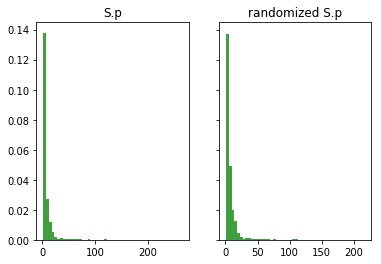

In [9]:
degree_distribution(sp_G,"S.p", new_sp_G, "randomized S.p")

We can see that the degree distribution plots do indeed look similar... we can also quantify this and see that this is indeed small

In [10]:
def degree_differences(G1, G2):
    G1_degs = dict(G1.degree)
    G2_degs = dict(G2.degree)
    diffs = []
    for node, deg1 in G1_degs.items():
        diffs.append(deg1 - G2_degs[node])
    return diffs

In [11]:
diffs = degree_differences(sp_G, new_sp_G)
print("Mean difference in degrees:", np.mean(diffs))

Mean difference in degrees: 0.30777479892761395


### Running HANDL on real and random graphs

We can now run HANDL on the real and randomized networks...

In [12]:
# Load PPI and HOMOLOG data
homologs_path = "../data/homologs/sc-sp/sp-sc-homologs.txt" 
homologs = handl.homologs_in_graphs(sp_G, sc_G, util.read_homolog_list(homologs_path))

Let us first define some functions to help compute dissimilarity scores, remove landmarks, and separate homologs from non-homologs.

In [13]:
def seperate_dissimilarity_scores(dissim_scores, 
                                  landmark_pair_idxs, homolog_pair_idxs):
    ''' Removes all pairs with at least one landmarks and separates homologs from non-homologs'''
    source_landmark_idxs, target_landmark_idxs = zip(*landmark_pair_idxs)
    source_homolog_idxs, target_homolog_idxs = zip(*homolog_pair_idxs)
    landmark_mask = np.zeros_like(dissim_scores, dtype=bool)
    
    source_landmark_target_all_mask = np.zeros_like(dissim_scores, dtype=bool)
    source_landmark_target_all_mask[source_landmark_idxs, :]  = True
    source_all_target_landmark_mask = np.zeros_like(dissim_scores, dtype=bool)
    source_all_target_landmark_mask[:, target_landmark_idxs]  = True
    landmark_landmark_mask = np.zeros_like(dissim_scores, dtype=bool) 
    landmark_landmark_mask[source_landmark_idxs, target_landmark_idxs] = True
    
    # Obtain landmark-landmark pairs
    L_L_diag_scores = dissim_scores[source_landmark_idxs, target_landmark_idxs]
    
    # Obtain landmark-landmark off diag pairs
    L_L_off_diag_mask = np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    L_L_off_diag_mask &= ~landmark_landmark_mask
    L_L_off_diag_scores = dissim_scores[L_L_off_diag_mask]
    
    # Landmark - Non-landmark pairs
    L_non_L_mask = source_landmark_target_all_mask ^ source_all_target_landmark_mask
    L_non_L_scores = dissim_scores[L_non_L_mask]
    
    # Hom - Hom pairs
    H_H_mask = np.zeros_like(dissim_scores, dtype=bool)
    H_H_mask[source_homolog_idxs, target_homolog_idxs] = True
    H_H_mask[source_landmark_idxs, target_landmark_idxs] = False
    H_H_scores = dissim_scores[H_H_mask]
    
    # Obtain other scores
    other_mask = np.ones_like(dissim_scores, dtype=np.bool)
    other_mask &= ~(source_landmark_target_all_mask | source_all_target_landmark_mask | H_H_mask )
    other_scores = dissim_scores[other_mask]
    

    return L_L_diag_scores,\
           L_L_off_diag_scores,\
           L_non_L_scores,\
           H_H_scores,\
            other_scores

def handl_dissimilarity_scores(source_G, target_G, homologs):
    # Calculate handl similarity scores
    outputs = handl.handl_embed_graphs(source_G, target_G, homologs,n_landmarks=400, return_idxs=True)
    ((source_C, source_nodes), (target_C_hat, target_nodes), landmark_idxs, homolog_idxs) = outputs
    non_landmark_hom_idxs = set(homolog_idxs)  - set(landmark_idxs)
    handl_similarity_scores = source_C.dot(target_C_hat.T)
    dissimilarity_scores = 1. / handl_similarity_scores
    dissimilarity_scores /= np.mean(dissimilarity_scores)
    return dissimilarity_scores, landmark_idxs, homolog_idxs

Let's also define a function that uses a kernel density estimator to plot the distribution of scores

In [14]:
def plot(scores_and_labels, xmax=0.6, font_size=12, line_width=2):
    from sklearn import neighbors

    # create and save plot
    plt.figure()
    
    # create kernel density estimator
    kde = neighbors.KernelDensity(kernel='gaussian', bandwidth = xmax / 20.)
    # need to add another dimension as required by sklearn
    # arrays passed to kde must be 2-dimensional
    X_plot = np.reshape(np.linspace(0, xmax, 500), (-1, 1))
    for xs, label in scores_and_labels:
        scores = np.ravel(xs) if len(xs) < 1e5 else np.random.choice(np.ravel(xs), int(1e5))
        kde.fit(np.reshape(scores, (-1, 1)))
        densities = kde.score_samples(X_plot)
        plt.plot(X_plot[:,0], np.exp(densities), lw = line_width,
                 label = label)
    plt.ylabel('Density', size = font_size)
    plt.xlabel('HANDL dissimilarity', size = font_size)
    plt.legend(loc='best', fontsize = font_size)

We can now compute the dissimilarity scores with respect to S.p to S.c HANDL embeddings.

In [15]:
dissimilarity_scores, landmark_idxs, homolog_idxs = \
    handl_dissimilarity_scores(sp_G, sc_G, homologs)

We can then separate scores for homolog pairs form non-homolog pairs.

In [16]:
L_L_diag_scores,\
L_L_off_diag_scores,\
L_non_L_scores,\
H_H_scores,\
other_scores = \
    seperate_dissimilarity_scores(dissimilarity_scores, landmark_idxs, homolog_idxs)
def n_elems(ndarray):
    return ndarray.shape[0] * ndarray.shape[1]

In [17]:
print(n_elems(dissimilarity_scores))
print (len(L_L_diag_scores)+ 
       len(L_L_off_diag_scores) +
       len(L_non_L_scores) +
       len(H_H_scores) +
       len(other_scores))

10460785
10460785


And we can plot the results...

Mean dissimilarity score for landmark - landmark diagonal pairs: 5.6757344777225294e-06
Mean dissimilarity score for landmark - landmark off diagonal pairs: 0.014140090202113658
Mean dissimilarity score for landmark - non_landmark pairs: 0.10393224672906642
Mean dissimilarity score for homologs pairs: 0.32801369839218014
Mean dissimilarity score for other pairs: 1.3341896480620803


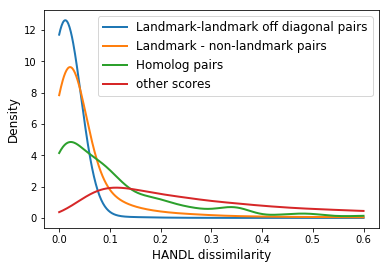

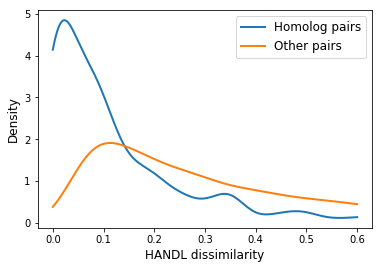

In [18]:
plot([(L_L_off_diag_scores, "Landmark-landmark off diagonal pairs"),
      (L_non_L_scores, "Landmark - non-landmark pairs"),
      (H_H_scores, "Homolog pairs"),
      (other_scores, "other scores")])

plot([(H_H_scores, "Homolog pairs"), 
      (other_scores, "Other pairs")])
print('Mean dissimilarity score for landmark - landmark diagonal pairs:', np.mean(L_L_diag_scores))
print('Mean dissimilarity score for landmark - landmark off diagonal pairs:', np.mean(L_L_off_diag_scores))
print('Mean dissimilarity score for landmark - non_landmark pairs:', np.mean(L_non_L_scores))
print('Mean dissimilarity score for homologs pairs:', np.mean(H_H_scores))
print('Mean dissimilarity score for other pairs:', np.mean(other_scores))



### We then repeat the above for random versions of S.c and S.p PPIs

In [19]:
rand_dissims, rand_L_idxs, rand_H_idxs = \
    handl_dissimilarity_scores(new_sp_G, new_sc_G, homologs)

Mean dissimilarity score for landmark - landmark diagonal pairs: 7.563099625716519e-06
Mean dissimilarity score for landmark - landmark off diagonal pairs: 0.02315641595331227
Mean dissimilarity score for landmark - non_landmark pairs: 0.11655348759217483
Mean dissimilarity score for homologs pairs: 0.7436806678683867
Mean dissimilarity score for other pairs: 1.329565165724489


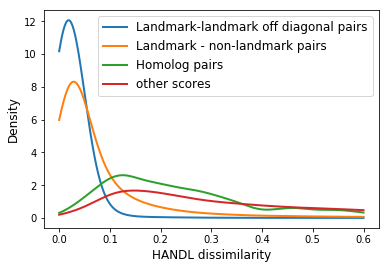

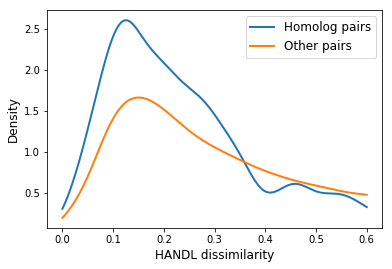

In [20]:
rand_L_L_diag_scores,\
rand_L_L_off_diag_scores,\
rand_L_non_L_scores,\
rand_H_H_scores,\
rand_other_scores = \
    seperate_dissimilarity_scores(rand_dissims, rand_L_idxs, rand_H_idxs)
    
plot([(rand_L_L_off_diag_scores, "Landmark-landmark off diagonal pairs"),
      (rand_L_non_L_scores, "Landmark - non-landmark pairs"),
      (rand_H_H_scores, "Homolog pairs"), 
      (rand_other_scores, "other scores")])

plot([(rand_H_H_scores, "Homolog pairs"), 
      (rand_other_scores, "Other pairs")])
print('Mean dissimilarity score for landmark - landmark diagonal pairs:', np.mean(rand_L_L_diag_scores))
print('Mean dissimilarity score for landmark - landmark off diagonal pairs:', np.mean(rand_L_L_off_diag_scores))
print('Mean dissimilarity score for landmark - non_landmark pairs:', np.mean(rand_L_non_L_scores))
print('Mean dissimilarity score for homologs pairs:', np.mean(rand_H_H_scores))
print('Mean dissimilarity score for other pairs:', np.mean(rand_other_scores))

### Measuring the significance of actual HANDL dissimilarities

To measure whether or not the observed difference in means from HANDL is signficant we perform a permutation test:

Null hypothesis: There is difference in means between HANDL dissimilarity scores of homologs and non-homologs is larger in random graphs conditioned on degree distributions

Permutation test:
0. Compute actual difference in mean dissimilarity between homologs and non homologs, $\delta$
1. Generate N random pairs of graphs given real source and target PPI pair
2. Compute HANDL dissimilarities for homologs and non-homologs
3. Compute differences in means of dissimilarities for the N trials
4. Count the number of differences in means in N trails that are less than $\delta$, $M$
5. Report p-value $\frac M N$ with corresponding confidence interval.



In [21]:
n_permutations = 5

In [22]:
rand_sc_graphs = [safe_perturbed_graph(sc_G) for i in range(n_permutations)]
rand_sp_graphs = [safe_perturbed_graph(sp_G) for i in range(n_permutations)]

In [23]:
means = [(np.mean(H_H_scores), np.mean(other_scores)) 
         for _,_,_, H_H_scores , other_scores in 
             [seperate_dissimilarity_scores(*handl_dissimilarity_scores(sp, sc, homologs)) 
              for sp, sc in zip(rand_sp_graphs, rand_sc_graphs)]]

In [24]:
diffs = [other_means - h_means for h_means, other_means in means]

print("Mean difference in means for random graphs:", np.mean(diffs))
print("Difference in means for real graphs:", np.mean(other_scores) - np.mean(H_H_scores))

print('p-val count: ', np.sum(np.array(diffs) > (np.mean(other_scores) - np.mean(H_H_scores))))
print('p-val: ', np.sum(np.array(diffs) > (np.mean(other_scores) - np.mean(H_H_scores))) / n_permutations)

Mean difference in means for random graphs: 0.5469614060782569
Difference in means for real graphs: 1.0061759496699
p-val count:  0
p-val:  0.0


Effect size?

In [25]:
std = np.std(diffs)
real_diff = np.mean(other_scores) - np.mean(H_H_scores)
mean_random_diff = np.mean(diffs)
effect_size = (real_diff - mean_random_diff) / std
print('Effect size:', effect_size)
print('Permutation test std:', std)

Effect size: 7.149348236595457
Permutation test std: 0.06423166537630046


### Some data exploration w.r.t homolog degree distributions...

In [26]:
sp_homs, sc_homs = list(zip(*homologs))

In [27]:
sp_hom_degrees = [deg for node, deg in sp_G.degree(sp_homs)]
sc_hom_degrees = [deg for node, deg in sc_G.degree(sc_homs)]
sp_degrees = [deg for node, deg in sp_G.degree if node not in set(sp_homs)]
sc_degrees = [deg for node, deg in sc_G.degree if node not in set(sc_homs)]

S.p: difference in homolog vs non-homolog mean degrees -1.8245693992305414
S.c: difference in homolog vs non-homolog mean degrees -1.8245693992305414


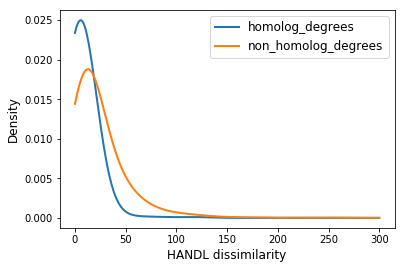

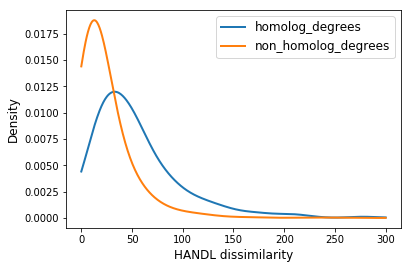

In [28]:
plot([(sp_hom_degrees, 'homolog_degrees'), (sc_degrees, 'non_homolog_degrees')], xmax=300)
print('S.p: difference in homolog vs non-homolog mean degrees', np.mean(sp_hom_degrees) - np.mean(sp_degrees))

plot([(sc_hom_degrees, 'homolog_degrees'), (sc_degrees, 'non_homolog_degrees')], xmax=300)
print('S.c: difference in homolog vs non-homolog mean degrees', np.mean(sp_hom_degrees) - np.mean(sp_degrees))